## Performed factosig with post-fitting ordering of the factors based on SS
- Then performed model- and stability-based stability significance calculation 

Load the experiment result folder 

In [1]:
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Point to the new FactoSig-only experiment
EXP_DIR = Path("/home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437")
K = 100  # number of factors
METHODS = ["factosig"]  # this run only has FactoSig

In [2]:
def load_method(exp_dir: Path, method: str, k: int):
    """
    Load saved DR arrays and metadata for a single method.

    Mirrors the loader in dr_result_nov9.ipynb.
    """
    mdir = exp_dir / "models" / f"{method}_{k}"
    if not mdir.exists():
        raise FileNotFoundError(f"Method directory not found: {mdir}")

    data = {"scores": None, "loadings": None, "extras": {}, "metrics": {}}

    # Core arrays
    scores_path = mdir / "scores.npy"
    loadings_path = mdir / "loadings.npy"
    if scores_path.exists():
        data["scores"] = np.load(scores_path)
    if loadings_path.exists():
        data["loadings"] = np.load(loadings_path)

    # Names
    obs_names_path = mdir / "obs_names.txt"
    var_names_path = mdir / "var_names.txt"
    if obs_names_path.exists():
        with open(obs_names_path, "r") as f:
            data["obs_names"] = [ln.strip() for ln in f]
    if var_names_path.exists():
        with open(var_names_path, "r") as f:
            data["var_names"] = [ln.strip() for ln in f]

    # Extras (psi, EV, EVR, singular values)
    for fname, key in [
        ("psi.npy", "psi"),
        ("explained_variance.npy", "explained_variance"),
        ("explained_variance_ratio.npy", "explained_variance_ratio"),
        ("singular_values.npy", "singular_values"),
    ]:
        p = mdir / fname
        if p.exists():
            data["extras"][key] = np.load(p)

    # Reconstruction error, if present
    rec_json = mdir / "reconstruction_error.json"
    if rec_json.exists():
        try:
            data["extras"]["reconstruction_error"] = json.loads(rec_json.read_text()).get("reconstruction_error")
        except Exception:
            pass

    # DR metrics
    met_json = mdir / "dr_metrics.json"
    if met_json.exists():
        try:
            data["metrics"] = json.loads(met_json.read_text())
        except Exception:
            pass

    return data

# Load the FactoSig results
DR = {m: load_method(EXP_DIR, m, K) for m in METHODS}
for m, d in DR.items():
    print(m, d["scores"].shape, d["loadings"].shape)

factosig (49480, 100) (15679, 100)


Look at SS loading share per factor in this new run 

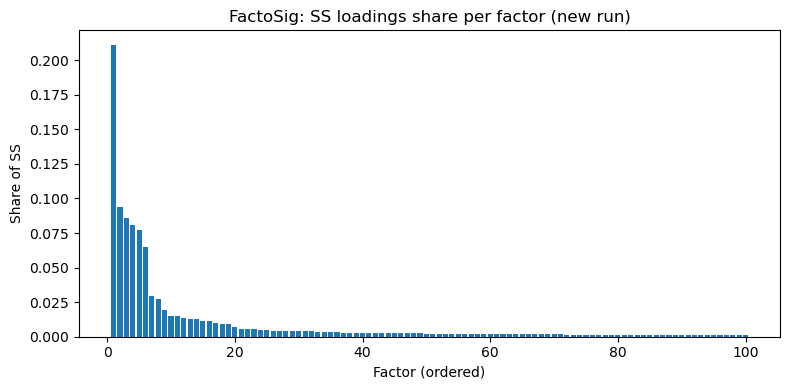

SS loadings sorted descending: True
Factor   1: SS=417.3502, share=0.2111
Factor   2: SS=185.5635, share=0.0938
Factor   3: SS=169.9470, share=0.0859
Factor   4: SS=159.2249, share=0.0805
Factor   5: SS=152.9214, share=0.0773


In [3]:
# Variance explained proxy for FactoSig: SS loadings share per factor
fs = DR.get("factosig")
L = fs["loadings"]
ss = (L**2).sum(axis=0)
share = ss / ss.sum()

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(np.arange(1, len(share) + 1), share)
ax.set_title("FactoSig: SS loadings share per factor (new run)")
ax.set_xlabel("Factor (ordered)")
ax.set_ylabel("Share of SS")
plt.tight_layout()
plt.show()

# Quick check: are SS values monotonically non-increasing?
is_sorted_desc = np.all(ss[:-1] >= ss[1:])
print("SS loadings sorted descending:", bool(is_sorted_desc))

# Optionally, inspect the first few values
for j in range(5):
    print(f"Factor {j+1:3d}: SS={ss[j]:.4f}, share={share[j]:.4f}")

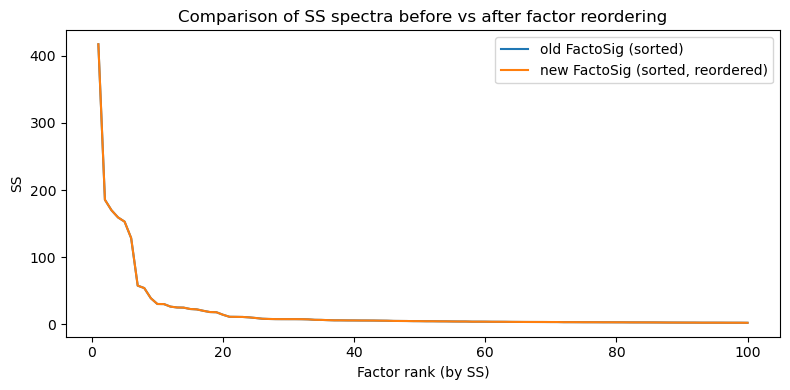

In [4]:
OLD_EXP_DIR = Path("/home/minhang/mds_project/sc_classification/scripts/experiments/20251109_205901_dr_suite_100_none__94e6712c")
old_fs = load_method(OLD_EXP_DIR, "factosig", K)

# get the ss of the old factosig 
ss_old = (old_fs["loadings"]**2).sum(axis=0)
ss_old_sorted = np.sort(ss_old)[::-1] # sorted in descending order
ss_new_sorted = np.sort(ss)[::-1] # sorted in descending order

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.arange(1, K+1), ss_old_sorted, label="old FactoSig (sorted)")
ax.plot(np.arange(1, K+1), ss_new_sorted, label="new FactoSig (sorted, reordered)")
ax.set_xlabel("Factor rank (by SS)")
ax.set_ylabel("SS")
ax.set_title("Comparison of SS spectra before vs after factor reordering")
ax.legend()
plt.tight_layout()
plt.show()

1. Filter the input like how we performed the fit in run_factosig_only.py
2. Attach the factosig result with the filtered adata

In [5]:
import scanpy as sc
from sc_classification.utils.experiment_manager import ExperimentManager
import yaml

# Load input h5ad path from config.yaml
with open(EXP_DIR / "config.yaml", "r") as f:
    cfg = yaml.safe_load(f)
input_h5ad = cfg.get("preprocessing", {}).get("used_input_h5ad")
print("Input h5ad:", input_h5ad)

adata0 = sc.read_h5ad(input_h5ad)

# Recreate the same cohort filtering as in run_factosig_only.py
if "timepoint_type" in adata0.obs.columns:
    adata0 = adata0[adata0.obs["timepoint_type"] == "MRD"].copy()
else:
    for c in ["sample", "Sample", "SAMPLE"]:
        if c in adata0.obs.columns:
            mask = adata0.obs[c].astype(str).str.contains("MRD", case=False, na=False)
            adata0 = adata0[mask].copy()
            break

label_col = next(c for c in ["CN.label", "cnLabel", "cn_label", "cnlabel"] if c in adata0.obs.columns)
adata0 = adata0[adata0.obs[label_col].isin(["cancer", "normal"])].copy()
if "patient" in adata0.obs.columns:
    has_mal = adata0.obs[adata0.obs[label_col] == "cancer"]["patient"].unique()
    adata0 = adata0[adata0.obs["patient"].isin(has_mal)].copy()
print("Cohort after filtering:", adata0.shape)

# Attach FactoSig DR arrays using ExperimentManager
em = ExperimentManager(str(EXP_DIR.parent))
exp_id = EXP_DIR.name
exp = em.load_experiment(exp_id)

method_keys = {
    "factosig": ("X_factosig", "FACTOSIG_loadings", "FACTOSIG_psi"),
}

adata = adata0.copy()
for m, (obsm_key, varm_key, var_psi_key) in method_keys.items():
    try:
        adata = exp.attach_dr_to_adata(
            adata,
            dr_method=m,
            n_components=K,
            obsm_key=obsm_key,
            varm_key=varm_key,
            var_psi_key=var_psi_key,
            strict_name_match=False,
        )
        print(f"Attached {m} to adata: {obsm_key}, {varm_key}")
    except Exception as e:
        print(f"Attach failed for {m}: {e}")

AD = adata  # keep handle

Input h5ad: /home/minhang/mds_project/data/cohort_adata/adata_mrd_standardized_oct7.h5ad
Cohort after filtering: (49480, 15679)
Loading experiment from: /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437
Attached factosig to adata: X_factosig, FACTOSIG_loadings


In [9]:
# check the patient = 03's CN.label
AD.obs[AD.obs["patient"] == "P03"]["CN.label"].value_counts()  

CN.label
normal    1569
cancer     758
Name: count, dtype: int64

Use other single cell properties [CN.label, patient] to create factosig-based UMAPs

Attributes available: ['CN.label', 'patient', 'predicted.annotation']


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computed UMAP for FactoSig: (49480, 2)


/tmp/ipykernel_3728289/1547296477.py:30: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(col) or col.dtype == object:


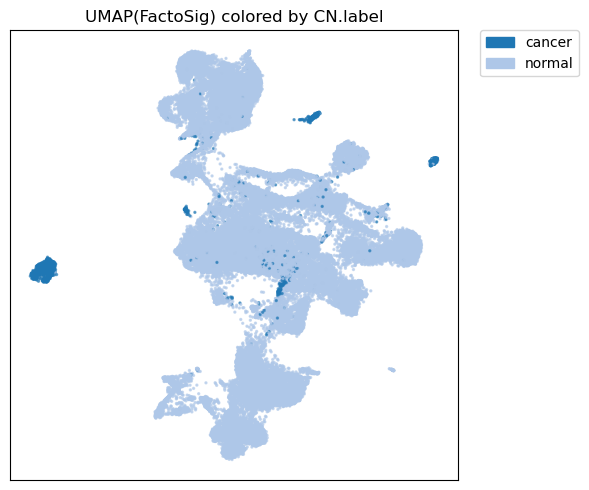

/tmp/ipykernel_3728289/1547296477.py:30: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(col) or col.dtype == object:


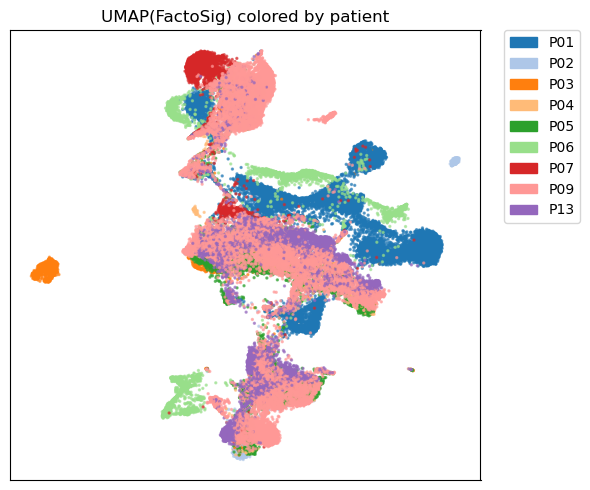

/tmp/ipykernel_3728289/1547296477.py:30: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(col) or col.dtype == object:


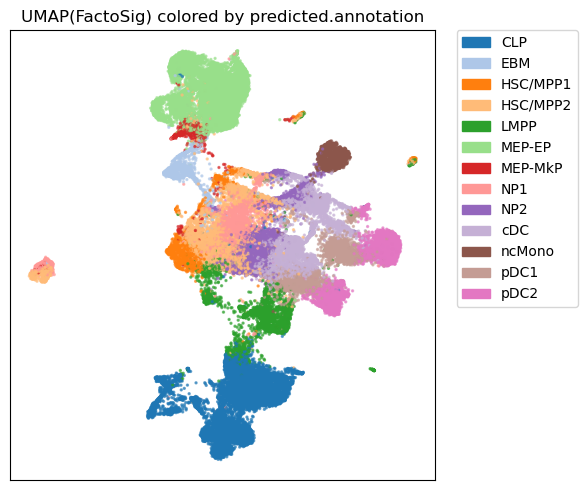

In [6]:
# UMAP based on FactoSig scores; color by CN.label, patient, etc.
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns

attrs = [c for c in ["CN.label", "patient", "predicted.annotation"] if c in AD.obs.columns]
print("Attributes available:", attrs)

try:
    import umap
except Exception:
    umap = None

if umap is None:
    print("umap-learn not installed; pip install umap-learn")
else:
    obsm_key, _, _ = method_keys["factosig"]
    if obsm_key not in AD.obsm:
        raise RuntimeError(f"Missing {obsm_key} in AD.obsm")

    Z = AD.obsm[obsm_key]
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42)
    emb = reducer.fit_transform(Z)
    AD.obsm["X_umap_factosig"] = emb
    print("Computed UMAP for FactoSig:", emb.shape)

    for a in attrs:
        plt.figure(figsize=(6, 5))
        col = AD.obs[a]
        if pd.api.types.is_categorical_dtype(col) or col.dtype == object:
            cats = col.astype(str)
            uniq = pd.Index(sorted(cats.unique()))
            cmap = dict(zip(uniq, sns.color_palette("tab20", n_colors=min(len(uniq), 20))))
            colors = cats.map(cmap).apply(
                lambda c: tuple(c) if isinstance(c, tuple) else (0.5, 0.5, 0.5)
            )
            colors = np.vstack(colors.values)
            plt.scatter(emb[:, 0], emb[:, 1], c=colors, s=2, alpha=0.6)

            legend_handles = [mpatches.Patch(color=c, label=l) for l, c in cmap.items()]
            plt.legend(
                handles=legend_handles,
                bbox_to_anchor=(1.05, 1),
                loc="upper left",
                borderaxespad=0.0,
            )

            plt.title(f"UMAP(FactoSig) colored by {a}")
        else:
            sca = plt.scatter(
                emb[:, 0], emb[:, 1], c=col.values, s=2, alpha=0.6, cmap="viridis"
            )
            plt.colorbar(sca)
            plt.title(f"UMAP(FactoSig) colored by {a}")
        plt.xticks([]); plt.yticks([])
        plt.tight_layout(); plt.show()

In [7]:
def plot_factosig_factors(
    factor1: int,
    factor2: int,
    obs_col: str | None = None,
    patient: str | int | None = None,
    point_size: float = 2.0,
    alpha: float = 0.6,
):
    """Plot single cells in FactoSig score space for two factors.

    Parameters
    ----------
    factor1, factor2
        1-based factor indices (1..K) to plot on x and y axes.
    obs_col
        Optional column in ``AD.obs`` to use for coloring (e.g. "predicted.annotation").
        If ``None``, points are shown in a single color.
    patient
        Optional patient identifier. If provided, subset to cells with
        ``AD.obs['patient'] == patient`` (string- or int-comparable).
    point_size, alpha
        Aesthetics for point size and transparency.
    """
    global AD, method_keys

    # Get FactoSig score matrix
    obsm_key, _, _ = method_keys["factosig"]
    if obsm_key not in AD.obsm:
        raise RuntimeError(f"Missing {obsm_key} in AD.obsm")

    Z = AD.obsm[obsm_key]
    n_cells, n_factors = Z.shape

    # Check factor indices (convert from 1-based to 0-based)
    if not (1 <= factor1 <= n_factors) or not (1 <= factor2 <= n_factors):
        raise ValueError(f"factor1 and factor2 must be in [1, {n_factors}], got {factor1}, {factor2}")

    f1 = factor1 - 1
    f2 = factor2 - 1

    # Subset by patient if requested
    mask = np.ones(n_cells, dtype=bool)
    if patient is not None:
        if "patient" not in AD.obs.columns:
            raise KeyError("Column 'patient' not found in AD.obs")
        pat_series = AD.obs["patient"].astype(str)
        mask = pat_series == str(patient)
        if mask.sum() == 0:
            raise ValueError(f"No cells found for patient={patient!r}")

    Z_sub = Z[mask, :]
    obs_sub = AD.obs.loc[mask]

    x = Z_sub[:, f1]
    y = Z_sub[:, f2]

    plt.figure(figsize=(6, 5))

    # Determine coloring
    used_col = None
    if obs_col is not None:
        if obs_col not in obs_sub.columns:
            print(f"Warning: obs_col {obs_col!r} not in AD.obs; using uniform color.")
        else:
            used_col = obs_sub[obs_col]

    if used_col is None:
        # Single-color scatter
        plt.scatter(x, y, s=point_size, alpha=alpha, color="tab:blue")
    else:
        col = used_col
        if pd.api.types.is_categorical_dtype(col) or col.dtype == object:
            cats = col.astype(str)
            uniq = pd.Index(sorted(cats.unique()))
            cmap = dict(zip(uniq, sns.color_palette("tab20", n_colors=min(len(uniq), 20))))
            colors = cats.map(cmap).apply(
                lambda c: tuple(c) if isinstance(c, tuple) else (0.5, 0.5, 0.5)
            )
            colors = np.vstack(colors.values)
            plt.scatter(x, y, c=colors, s=point_size, alpha=alpha)

            legend_handles = [mpatches.Patch(color=c, label=l) for l, c in cmap.items()]
            plt.legend(
                handles=legend_handles,
                bbox_to_anchor=(1.05, 1),
                loc="upper left",
                borderaxespad=0.0,
            )
        else:
            sca = plt.scatter(
                x,
                y,
                c=col.values,
                s=point_size,
                alpha=alpha,
                cmap="viridis",
            )
            plt.colorbar(sca, label=obs_col)

    title = f"FactoSig factor {factor1} vs {factor2}"
    if patient is not None:
        title += f" (patient={patient})"
    if obs_col is not None:
        title += f"\ncolored by {obs_col}"

    plt.title(title)
    plt.xlabel(f"Factor {factor1}")
    plt.ylabel(f"Factor {factor2}")
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_3728289/209782450.py:72: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(col) or col.dtype == object:


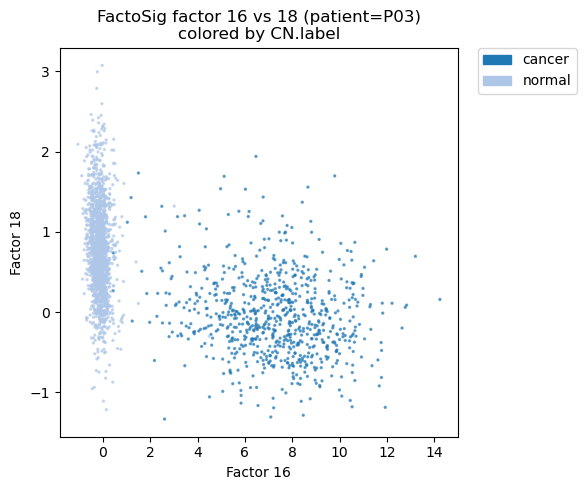

In [8]:
plot_factosig_factors(16, 18, obs_col='CN.label', patient = "P03")

/tmp/ipykernel_3728289/209782450.py:72: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(col) or col.dtype == object:


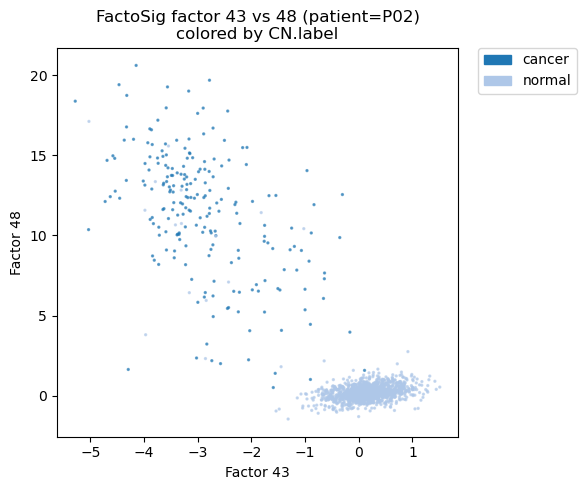

In [9]:
plot_factosig_factors(43, 48, obs_col='CN.label', patient = "P02")

/tmp/ipykernel_3728289/209782450.py:72: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(col) or col.dtype == object:


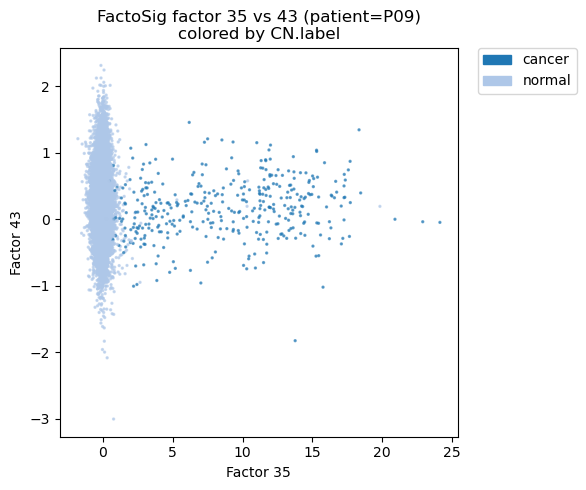

In [10]:
plot_factosig_factors(35, 43, obs_col='CN.label', patient='P09')

/tmp/ipykernel_3728289/209782450.py:72: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(col) or col.dtype == object:


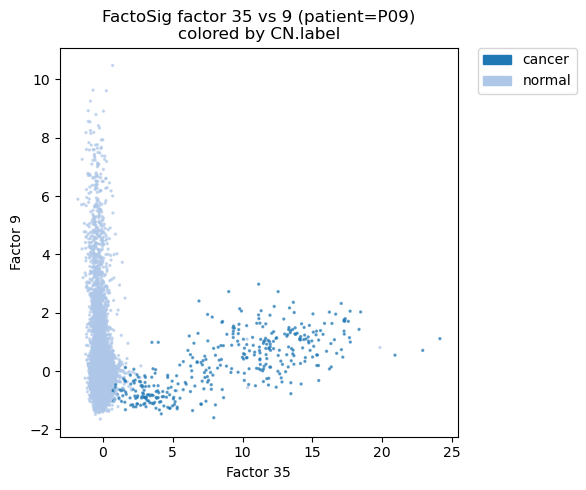

In [11]:
plot_factosig_factors(35, 9, obs_col='CN.label', patient='P09')

In [ ]:
plot_factosig_factors(1, 2, obs_col='CN.label', patient='P09')

In [ ]:
# save a compressed version of AD
# AD.write_h5ad('MRD_adata_factosig_based_UMAP.h5ad', compression='gzip')

Perform GSEA on factor gene loading (only using loading value)
- plot the overall distribution of hits

In [6]:
# Parameters for GSEA
from typing import Optional

GSEA_THREADS = 8
GSEA_PERM = 1000
GSEA_MIN_SIZE = 15
GSEA_MAX_SIZE = 500

# Path to Hallmark .gmt (adjust if your path is different)
HALLMARK_GMT = Path("/home/minhang/mds_project/data/cohort_adata/gene_sets/h.all.v2024.1.Hs.symbols.gmt")

FACTOR_INTP_DIR = EXP_DIR / "analysis" / "factor_interpretation"
FACTOR_INTP_DIR.mkdir(parents=True, exist_ok=True)

try:
    import gseapy as gp
except Exception as e:
    print("Install gseapy to run GSEA: pip install gseapy")
    gp = None


def run_or_read_prerank(series: pd.Series, gene_sets: str | Path, out_dir: Path) -> Optional[pd.DataFrame]:
    out_dir.mkdir(parents=True, exist_ok=True)
    report_csv = out_dir / "gseapy.gene_set.prerank.report.csv"
    if report_csv.exists():
        try:
            df = pd.read_csv(report_csv, sep="\t")
        except Exception:
            df = pd.read_csv(report_csv)
        return df
    if gp is None:
        return None
    df_rnk = series.reset_index()
    df_rnk.columns = ["gene", "score"]
    res = gp.prerank(
        rnk=df_rnk,
        gene_sets=str(gene_sets),
        threads=GSEA_THREADS,
        permutation_num=GSEA_PERM,
        outdir=str(out_dir),
        seed=0,
        min_size=GSEA_MIN_SIZE,
        max_size=GSEA_MAX_SIZE,
        no_plot=True,
        format="png",
    )
    return res.res2d.copy()

2025-11-17 02:23:28,970 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Running/reading GSEA for factosig ...


2025-11-17 02:23:30,883 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-11-17 02:23:32,523 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-11-17 02:23:39,020 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-11-17 02:23:40,613 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-11-17 02:23:42,170 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-11-17 02:23:43,746 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

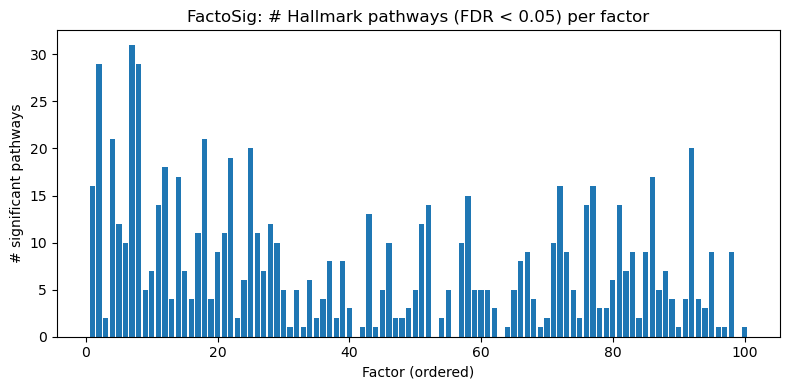

In [7]:
# Run/collect GSEA for FactoSig factors
GSEA_COUNTS = {}

for m in METHODS:
    print(f"Running/reading GSEA for {m} ...")
    L = DR[m]["loadings"]
    genes = np.array(DR[m]["var_names"])
    out_root = FACTOR_INTP_DIR / f"{m}_gsea"
    out_root.mkdir(parents=True, exist_ok=True)
    n_factors = L.shape[1]
    counts = []
    for j in range(n_factors):
        rank = pd.Series(L[:, j], index=genes).sort_values(ascending=False)
        out_dir = out_root / f"{m}{j+1}"
        df = run_or_read_prerank(rank, HALLMARK_GMT, out_dir)
        if df is None:
            continue
        qcols = [c for c in ["FDR q-val", "fdr", "fdr_q-val", "fdr_q_value"] if c in df.columns]
        if qcols:
            qcol = qcols[0]
            n_sig = int((df[qcol] < 0.05).sum())
        else:
            n_sig = np.nan
        counts.append({"factor": j, "n_sig": n_sig})
    GSEA_COUNTS[m] = pd.DataFrame(counts)

# Plot # significant Hallmark pathways per factor (FactoSig only)
fig, ax = plt.subplots(figsize=(8, 4))
dfc = GSEA_COUNTS.get("factosig", pd.DataFrame())
if dfc.empty:
    ax.text(0.5, 0.5, "No GSEA results for factosig", ha="center")
    ax.set_title("factosig")
else:
    ax.bar(dfc["factor"].values + 1, dfc["n_sig"].values)
    ax.set_title("FactoSig: # Hallmark pathways (FDR < 0.05) per factor")
    ax.set_xlabel("Factor (ordered)")
    ax.set_ylabel("# significant pathways")
plt.tight_layout(); plt.show()

Create GSEA summary plot

In [8]:
# Optional: use ExperimentAnalyzer to create GSEA summary barplots per factor
from sc_classification.utils.experiment_analysis import ExperimentAnalyzer

experiments_base_dir = EXP_DIR.parent
analyzer = ExperimentAnalyzer(str(experiments_base_dir))

for m in METHODS:
    print(f"Creating GSEA summary plots for {m} ...")
    out_root = FACTOR_INTP_DIR / f"{m}_gsea"
    n_factors = DR[m]["loadings"].shape[1]
    for j in range(n_factors):
        factor_name = f"{m.upper()} Factor {j+1}"
        gsea_dir = out_root / f"{m}{j+1}"
        csv_path = gsea_dir / "gseapy.gene_set.prerank.report.csv"
        plot_path = gsea_dir / f"GSEA_summary_barplot_{m}{j+1}.png"
        if not csv_path.exists():
            continue
        analyzer._plot_gsea_results(
            csv_path=str(csv_path),
            factor_name=factor_name,
            gene_set=str(HALLMARK_GMT),
            output_path=str(plot_path),
        )
print("Done.")

Creating GSEA summary plots for factosig ...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')
/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')
/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the 

Done.


GSEA with model-based sig 

In [33]:
from pathlib import Path
import numpy as np
import pandas as pd

EXP_DIR = Path("/home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437")
K = 100
METHOD = "factosig"

# Load loadings and gene names from the experiment cache
model_dir = EXP_DIR / "models" / f"{METHOD}_{K}"
L = np.load(model_dir / "loadings.npy")          # (p, k)
with open(model_dir / "var_names.txt") as f:
    genes = np.array([ln.strip() for ln in f])

print("Loadings shape:", L.shape, " #genes:", len(genes))

# Load model-based significance (se/z/p/q) we just cached
sig_npz_path = model_dir / "significance" / "model_significance.npz"
sig_npz = np.load(sig_npz_path)
q_model = sig_npz["q"]                           # (p, k)
print("q_model shape:", q_model.shape)

Loadings shape: (15679, 100)  #genes: 15679
q_model shape: (15679, 100)


In [34]:
# Combined scores: -log10(q) * loading, per gene × factor
eps = 1e-300
q_clipped = np.clip(q_model, eps, 1.0)
weight = -np.log10(q_clipped)                    # higher = more significant
combined_score = weight * L                      # sign comes from L

print("combined_score shape:", combined_score.shape)

combined_score shape: (15679, 100)


In [37]:
import gseapy as gp
from typing import Optional

HALLMARK_GMT = Path("/home/minhang/mds_project/data/cohort_adata/gene_sets/h.all.v2024.1.Hs.symbols.gmt")

MODEL_SIG_GSEA_DIR = EXP_DIR / "analysis" / "factor_interpretation" / "model_sig_gsea"
MODEL_SIG_GSEA_DIR.mkdir(parents=True, exist_ok=True)

def run_or_read_prerank(series: pd.Series, gene_sets: str | Path, out_dir: Path) -> Optional[pd.DataFrame]:
    out_dir.mkdir(parents=True, exist_ok=True)
    report_csv = out_dir / "gseapy.gene_set.prerank.report.csv"
    if report_csv.exists():
        # re-use existing result
        try:
            df = pd.read_csv(report_csv, sep="\t")
        except Exception:
            df = pd.read_csv(report_csv)
        return df

    df_rnk = series.reset_index()
    df_rnk.columns = ["gene", "score"]
    res = gp.prerank(
        rnk=df_rnk,
        gene_sets=str(gene_sets),
        threads=8,
        permutation_num=1000,
        outdir=str(out_dir),
        seed=0,
        min_size=15,
        max_size=500,
        no_plot=True,
        format="png",
    )
    return res.res2d.copy()

In [38]:
GSEA_COUNTS_MODEL = []

for j in range(combined_score.shape[1]):
    # Combined rank: -log10(q) * L for factor j
    score_j = combined_score[:, j]
    rank_series = pd.Series(score_j, index=genes).sort_values(ascending=False)

    out_dir = MODEL_SIG_GSEA_DIR / f"factosig{j+1}"
    print(f"Factor {j+1}: GSEA (model-based rank) →", out_dir)
    df_res = run_or_read_prerank(rank_series, HALLMARK_GMT, out_dir)
    if df_res is None:
        continue

    # Count significant Hallmark sets (FDR < 0.05)
    qcols = [c for c in ["FDR q-val", "fdr", "fdr_q-val", "fdr_q_value"] if c in df_res.columns]
    if qcols:
        qcol = qcols[0]
        n_sig = int((df_res[qcol] < 0.05).sum())
    else:
        n_sig = np.nan
    GSEA_COUNTS_MODEL.append({"factor": j+1, "n_sig": n_sig})

GSEA_COUNTS_MODEL = pd.DataFrame(GSEA_COUNTS_MODEL)
GSEA_COUNTS_MODEL.head()

Factor 1: GSEA (model-based rank) → /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/factor_interpretation/model_sig_gsea/factosig1
Factor 2: GSEA (model-based rank) → /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/factor_interpretation/model_sig_gsea/factosig2
Factor 3: GSEA (model-based rank) → /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/factor_interpretation/model_sig_gsea/factosig3
Factor 4: GSEA (model-based rank) → /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/factor_interpretation/model_sig_gsea/factosig4
Factor 5: GSEA (model-based rank) → /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/factor_interpretation/

2025-11-17 23:12:38,181 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Factor 12: GSEA (model-based rank) → /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/factor_interpretation/model_sig_gsea/factosig12
Factor 13: GSEA (model-based rank) → /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/factor_interpretation/model_sig_gsea/factosig13
Factor 14: GSEA (model-based rank) → /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/factor_interpretation/model_sig_gsea/factosig14
Factor 15: GSEA (model-based rank) → /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/factor_interpretation/model_sig_gsea/factosig15
Factor 16: GSEA (model-based rank) → /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/factor_interp

,factor,n_sig
0,1,7
1,2,13
2,3,0
3,4,1
4,5,3


In [40]:
MODEL_SIG_GSEA_DIR

PosixPath('/home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/factor_interpretation/model_sig_gsea')

In [41]:
# Optional: use ExperimentAnalyzer to create GSEA summary barplots per factor
from sc_classification.utils.experiment_analysis import ExperimentAnalyzer

experiments_base_dir = EXP_DIR.parent
analyzer = ExperimentAnalyzer(str(experiments_base_dir))

for m in METHODS:
    print(f"Creating GSEA summary plots for {m} ...")
    out_root = MODEL_SIG_GSEA_DIR
    n_factors = DR[m]["loadings"].shape[1]
    for j in range(n_factors):
        factor_name = f"{m.upper()} Factor {j+1}"
        gsea_dir = out_root / f"{m}{j+1}"
        csv_path = gsea_dir / "gseapy.gene_set.prerank.report.csv"
        plot_path = gsea_dir / f"GSEA_summary_barplot_{m}{j+1}.png"
        if not csv_path.exists():
            continue
        analyzer._plot_gsea_results(
            csv_path=str(csv_path),
            factor_name=factor_name,
            gene_set=str(HALLMARK_GMT),
            output_path=str(plot_path),
        )
print("Done.")

Creating GSEA summary plots for factosig ...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')
/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')
/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the 

Done.


Using signed AUC as separation score
- plot the AUC separation score (overall, not per-patient)

,factosig
count,100.000000
mean,0.096897
std,0.531190
min,-0.686304
25%,-0.515897
50%,0.508658
75%,0.529307
max,0.841541


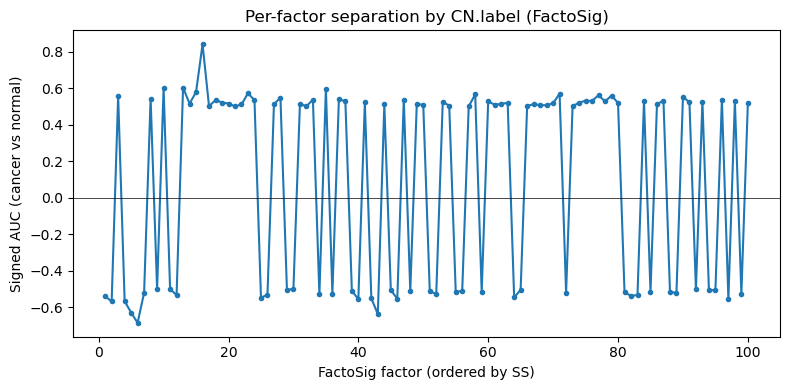

In [9]:
from sklearn.metrics import roc_auc_score

def signed_auc(y_true: np.ndarray, z: np.ndarray) -> float:
    # AUC in [0,1]; sign by median difference cancer - normal
    auc = roc_auc_score(y_true, z)
    sgn = np.sign(np.median(z[y_true == 1]) - np.median(z[y_true == 0]))
    auc_signed = sgn * (auc if auc >= 0.5 else (1 - auc))
    return float(auc_signed)

label_col = next(c for c in ["CN.label", "cnLabel", "cn_label", "cnlabel"] if c in AD.obs.columns)
label = AD.obs[label_col].astype(str).map({"normal": 0, "cancer": 1}).to_numpy()  # 0: normal, 1: cancer
patients = AD.obs["patient"].astype(str) if "patient" in AD.obs.columns else pd.Series(["ALL"] * AD.n_obs)

# plot the overall distribution of signed AUC (not per-patient)
sep_all = {}
for m in METHODS:
    obsm_key, _, _ = method_keys[m]
    if obsm_key not in AD.obsm:
        continue
    Z = AD.obsm[obsm_key]
    sep_all[m] = [signed_auc(label, Z[:, j]) for j in range(Z.shape[1])]

sep_all_df = pd.DataFrame(sep_all)
display(sep_all_df.describe())

plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, K+1), sep_all_df["factosig"].values, marker="o", ms=3)
plt.axhline(0, color="k", linewidth=0.5)
plt.xlabel("FactoSig factor (ordered by SS)")
plt.ylabel("Signed AUC (cancer vs normal)")
plt.title("Per-factor separation by CN.label (FactoSig)")
plt.tight_layout(); plt.show()

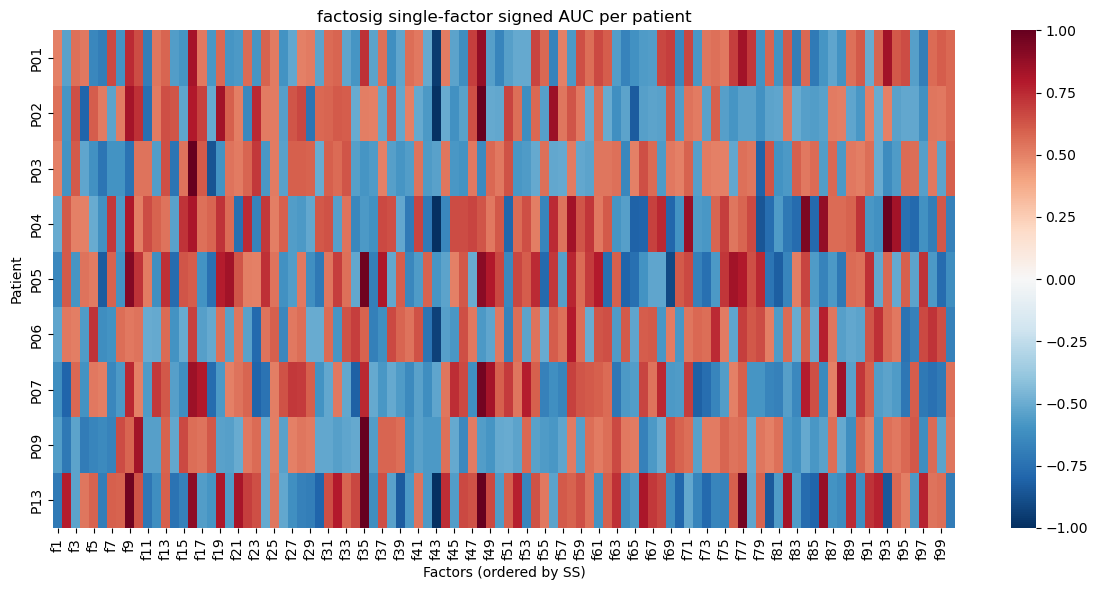

In [10]:
# Per-patient separation score heatmap for FactoSig
def patient_separation_scores(method: str) -> pd.DataFrame:
    Z = AD.obsm[method_keys[method][0]]
    p = AD.obs["patient"].astype(str)
    y = label
    rows = {}
    for pid in sorted(p.unique()):
        idx = np.flatnonzero(p == pid)
        if idx.size < 10:
            continue
        y_p = y[idx]
        Zp = Z[idx, :]
        rows[pid] = [signed_auc(y_p, Zp[:, j]) for j in range(Zp.shape[1])]
    return pd.DataFrame.from_dict(rows, orient="index", columns=[f"f{j+1}" for j in range(Z.shape[1])])

method_for_heatmap = "factosig"
pat_df = patient_separation_scores(method_for_heatmap)
plt.figure(figsize=(12, max(6, pat_df.shape[0] * 0.25)))
sns.heatmap(pat_df, cmap="RdBu_r", center=0, vmin=-1, vmax=1)
plt.title(f"{method_for_heatmap} single-factor signed AUC per patient")
plt.xlabel("Factors (ordered by SS)")
plt.ylabel("Patient")
plt.tight_layout(); plt.show()

In [11]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

EXP_DIR = Path("/home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437")

SUMMARY_DIR = EXP_DIR / "analysis" / "summary_plots"
SUMMARY_DIR.mkdir(parents=True, exist_ok=True)

CORR_DIR = EXP_DIR / "analysis" / "corr_matrices"
CORR_DIR.mkdir(parents=True, exist_ok=True)

Create hierarchical clustering of the signed AUC separation score

In [12]:
def plot_clustered_signed_auc(scores_df: pd.DataFrame,
                              abs_threshold: float = 0.5,
                              patients_to_exclude=None,
                              title: str = "",
                              figsize_scale=(0.40, 0.55),
                              center=0,
                              output_path: str | Path | None = None,
                              dpi: int = 300):
    import seaborn as sns
    if patients_to_exclude is None:
        patients_to_exclude = []
    filt_df = scores_df.loc[:, (scores_df.abs() > abs_threshold).any(axis=0)]
    if filt_df.empty:
        print("No factors pass the |score| threshold; plotting all factors instead.")
        filt_df = scores_df.copy()
    filt_df = filt_df.drop(index=patients_to_exclude, errors="ignore")
    heatmap_data = filt_df.fillna(0.0)

    w = max(12, heatmap_data.shape[1] * figsize_scale[0])
    h = max(6, heatmap_data.shape[0] * figsize_scale[1])
    cg = sns.clustermap(
        heatmap_data,
        method="average",
        metric="euclidean",
        cmap="RdBu_r",
        center=center,
        vmin=-1, vmax=1,
        figsize=(w, h),
        cbar_kws={"label": "Separation Score (signed AUC)"},
    )
    cg.fig.suptitle(title or f"Factors with any |score| > {abs_threshold}", fontsize=16, y=1.03)
    cg.ax_heatmap.set_title("")
    plt.setp(cg.ax_heatmap.get_xticklabels(), fontsize=8, rotation=90)
    plt.setp(cg.ax_heatmap.get_yticklabels(), fontsize=9)
    cg.ax_heatmap.set_xlabel("Factors")
    cg.ax_heatmap.set_ylabel("Patients")

    if output_path is not None:
        output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        cg.fig.savefig(output_path, dpi=dpi, bbox_inches="tight")
        print(f"Saved clustered signed AUC heatmap to: {output_path}")
        plt.close(cg.fig)
    else:
        plt.show()

In [13]:
import numpy as np
import pandas as pd

# Pick the CN.label column actually present in AD
label_col = next(c for c in ["CN.label", "cnLabel", "cn_label", "cnlabel"] if c in AD.obs.columns)

# Binary label: 0 = normal, 1 = cancer
label = AD.obs[label_col].astype(str).map({"normal": 0, "cancer": 1}).to_numpy()

print("Using label column:", label_col, " | label shape:", label.shape)

Using label column: CN.label  | label shape: (49480,)


In [21]:
# Build per-patient signed AUC for FactoSig
def patient_separation_scores(method: str) -> pd.DataFrame:
    Z = AD.obsm[method_keys[method][0]]
    p = AD.obs["patient"].astype(str)
    y = label
    rows = {}
    for pid in sorted(p.unique()):
        idx = np.flatnonzero(p == pid)
        if idx.size < 10:
            continue
        y_p = y[idx]
        Zp = Z[idx, :]
        rows[pid] = [signed_auc(y_p, Zp[:, j]) for j in range(Zp.shape[1])]
    return pd.DataFrame.from_dict(rows, orient="index", columns=[f"f{j+1}" for j in range(Z.shape[1])])

if "patient" in AD.obs.columns and method_keys["factosig"][0] in AD.obsm:
    df_pat = patient_separation_scores("factosig")
    out_path = SUMMARY_DIR / "factosig_signed_auc_per_patient_clustered_0.85.png"
    plot_clustered_signed_auc(
        df_pat,
        abs_threshold=0.85,
        patients_to_exclude=[],
        title="FACTOSIG: Distinguishing Power (|score| > 0.85)",
        figsize_scale=(0.40, 0.60),
        center=0,
        output_path=out_path,
        dpi=600,
    )

Saved clustered signed AUC heatmap to: /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/summary_plots/factosig_signed_auc_per_patient_clustered_0.85.png


In [15]:
AD

AnnData object with n_obs × n_vars = 49480 × 15679
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'predicted.annotation', 'predicted.annotation.score', 'predicted.pseudotime', 'predicted.pseudotime.score', 'CN.label', 'Days from SCT', 'Days.from.Relapse', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'ID', 'modality', 'chr', 'start', 'end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells

Overlay signed AUC score to share SS plot

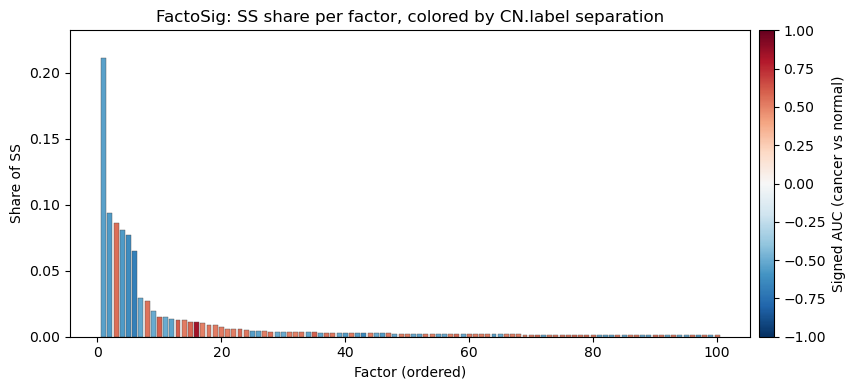

In [16]:
# share -> computed as above; sep_all_df["factosig"] holds per-factor signed AUC
sep_scores = sep_all_df["factosig"].to_numpy()
if sep_scores.shape[0] != share.shape[0]:
    raise ValueError("Mismatch between number of factors in share and signed AUC.")

x = np.arange(1, len(share) + 1)
norm = plt.Normalize(vmin=-1, vmax=1)
cmap = plt.get_cmap("RdBu_r")
colors = cmap(norm(sep_scores))

fig, ax = plt.subplots(figsize=(9, 4))
bars = ax.bar(x, share, color=colors, edgecolor="0.3", linewidth=0.3)
ax.set_title("FactoSig: SS share per factor, colored by CN.label separation")
ax.set_xlabel("Factor (ordered)")
ax.set_ylabel("Share of SS")
ax.set_ylim(0, share.max() * 1.1)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label("Signed AUC (cancer vs normal)")

plt.tight_layout()
plt.show()

Add second y-axis showing AUC score to shared SS plot

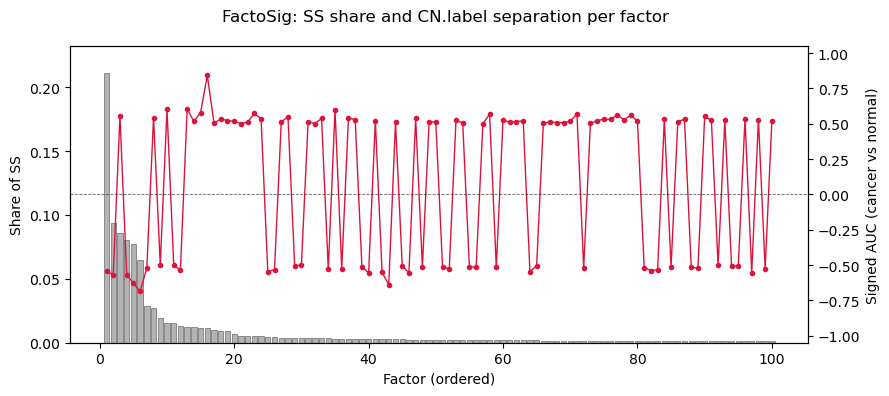

In [17]:
# share and ss already defined above
sep_scores = sep_all_df["factosig"].to_numpy()
if sep_scores.shape[0] != share.shape[0]:
    raise ValueError("Factor count mismatch between SS share and signed AUC.")

x = np.arange(1, len(share) + 1)

fig, ax1 = plt.subplots(figsize=(9, 4))
ax1.bar(x, share, color="0.7", edgecolor="0.3", linewidth=0.4)
ax1.set_xlabel("Factor (ordered)")
ax1.set_ylabel("Share of SS")
ax1.set_ylim(0, share.max() * 1.1)

ax2 = ax1.twinx()
ax2.plot(x, sep_scores, color="crimson", marker="o", markersize=3, linewidth=1)
ax2.axhline(0, color="k", linewidth=0.6, linestyle="--", alpha=0.6)
ax2.set_ylabel("Signed AUC (cancer vs normal)")
ax2.set_ylim(-1.05, 1.05)

fig.suptitle("FactoSig: SS share and CN.label separation per factor")
fig.tight_layout()
plt.show()

In [18]:
# Requires: share (SS loadings share per factor), df_pat from patient_separation_scores("factosig")

per_patient_dir = SUMMARY_DIR / "factosig_ss_sep_per_patient"
per_patient_dir.mkdir(parents=True, exist_ok=True)

x = np.arange(1, len(share) + 1)

for pid in df_pat.index:
    sep_scores = df_pat.loc[pid].to_numpy()
    if sep_scores.shape[0] != share.shape[0]:
        raise ValueError(f"{pid}: factor count mismatch between SS share and signed AUC.")

    fig, ax1 = plt.subplots(figsize=(9, 4))
    ax1.bar(x, share, color="0.75", edgecolor="0.4", linewidth=0.3)
    ax1.set_xlabel("Factor (ordered)")
    ax1.set_ylabel("Share of SS")
    ax1.set_ylim(0, share.max() * 1.1)

    ax2 = ax1.twinx()
    ax2.plot(x, sep_scores, color="crimson", marker="o", markersize=3, linewidth=1)
    ax2.axhline(0, color="k", linestyle="--", linewidth=0.6, alpha=0.6)
    ax2.set_ylabel(f"Signed AUC (patient {pid})")
    ax2.set_ylim(-1.05, 1.05)

    fig.suptitle(f"FactoSig: SS share + CN.label separation per factor ({pid})")
    fig.tight_layout()

    out_path = per_patient_dir / f"{pid}_factosig_ss_sep.png"
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

print(f"Saved patient plots to {per_patient_dir}")

Saved patient plots to /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/summary_plots/factosig_ss_sep_per_patient


Create corr matrix of the latent factors

In [22]:
def global_corr_matrix(method: str) -> pd.DataFrame:
    Z = AD.obsm[method_keys[method][0]]
    y = label.astype(float)
    Z_plus_y = np.column_stack([Z, y])
    cols = [*(map(str, range(1, Z.shape[1] + 1))), "CN.label"]
    M = pd.DataFrame(Z_plus_y, columns=cols).corr()
    return M

def plot_corr_clustermap(M: pd.DataFrame, title: str = "",
                         size_scale=(0.22, 0.26), ticksize=6,
                         vmin=-1, vmax=1, center=0, cmap="RdBu_r",
                         output_path: str | Path | None = None,
                         dpi: int = 300):
    n_rows, n_cols = M.shape
    w = max(14, n_cols * size_scale[0])
    h = max(12, n_rows * size_scale[1])
    cg = sns.clustermap(
        M,
        cmap=cmap,
        center=center,
        vmin=vmin, vmax=vmax,
        method="average", metric="euclidean",
        figsize=(w, h),
        xticklabels=True, yticklabels=True,
    )
    cg.fig.suptitle(title, fontsize=14, y=1.02)
    plt.setp(cg.ax_heatmap.get_xticklabels(), fontsize=ticksize, rotation=90)
    plt.setp(cg.ax_heatmap.get_yticklabels(), fontsize=ticksize)

    if output_path is not None:
        output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        cg.fig.savefig(output_path, dpi=dpi, bbox_inches="tight")
        print(f"Saved corr clustermap to: {output_path}")
        plt.close(cg.fig)
    else:
        plt.show()

Global corr matrix (across patients)

In [24]:
M_fs = global_corr_matrix("factosig")
out_global = CORR_DIR / "factosig_global_corr_plus_CNlabel.png"
plot_corr_clustermap(
    M_fs,
    title="FACTOSIG: corr matrix (+ CN.label)",
    size_scale=(0.22, 0.26),
    ticksize=5,
    output_path=out_global,
    dpi=600,
)

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Saved corr clustermap to: /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/corr_matrices/factosig_global_corr_plus_CNlabel.png


Per-patient corr matrix

In [27]:
AD.obs['patient'].unique()

['P01', 'P03', 'P02', 'P05', 'P04', 'P06', 'P07', 'P09', 'P13']
Categories (9, object): ['P01', 'P02', 'P03', 'P04', ..., 'P06', 'P07', 'P09', 'P13']

In [30]:
p = AD.obs["patient"].astype(str)
counts = p.value_counts()
sel_patients = counts.index.astype(str).tolist()

In [31]:
sel_patients

['P09', 'P01', 'P13', 'P05', 'P06', 'P03', 'P07', 'P02', 'P04']

In [32]:
if method_keys["factosig"][0] in AD.obsm and "patient" in AD.obs.columns:
    Z = AD.obsm[method_keys["factosig"][0]]
    p = AD.obs["patient"].astype(str)
    y = label.astype(float)

    counts = p.value_counts()
    sel_patients = counts.index.astype(str).tolist()

    for pid in sel_patients:
        idx = np.flatnonzero(p == pid)
        if idx.size < 10:
            continue
        Zp = Z[idx, :]
        yp = y[idx]
        Z_plus_y = np.column_stack([Zp, yp])
        cols = [*(map(str, range(1, Zp.shape[1] + 1))), "CN.label"]
        M = pd.DataFrame(Z_plus_y, columns=cols).corr()
        out_pid = CORR_DIR / f"factosig_patient_{pid}_corr_plus_CNlabel.png"
        plot_corr_clustermap(
            M,
            title=f"FACTOSIG: Patient {pid} corr (+ CN.label)",
            size_scale=(0.22, 0.26),
            ticksize=5,
            output_path=out_pid,
            dpi=600,
        )

/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Saved corr clustermap to: /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/corr_matrices/factosig_patient_P09_corr_plus_CNlabel.png


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Saved corr clustermap to: /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/corr_matrices/factosig_patient_P01_corr_plus_CNlabel.png


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Saved corr clustermap to: /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/corr_matrices/factosig_patient_P13_corr_plus_CNlabel.png


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Saved corr clustermap to: /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/corr_matrices/factosig_patient_P05_corr_plus_CNlabel.png


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Saved corr clustermap to: /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/corr_matrices/factosig_patient_P06_corr_plus_CNlabel.png


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Saved corr clustermap to: /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/corr_matrices/factosig_patient_P03_corr_plus_CNlabel.png


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Saved corr clustermap to: /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/corr_matrices/factosig_patient_P07_corr_plus_CNlabel.png


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Saved corr clustermap to: /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/corr_matrices/factosig_patient_P02_corr_plus_CNlabel.png


/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/minhang/miniconda3/envs/sc-factosig-gpu/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Saved corr clustermap to: /home/minhang/mds_project/sc_classification/scripts/experiments/20251115_054547_factosig_only_100_none__ec10d437/analysis/corr_matrices/factosig_patient_P04_corr_plus_CNlabel.png
